# Transformer Experiments
I was thinking about how the attention layer in transformers literally just uses linear layers with a couple dot product operations. I wondered if such a process was learnable by a simple neural network, but in my brainstorm sesh with ChatGPT, it didn't like the idea. In the 'Attention is all you need' paper, they talk about how attention sort of reduces the path between dependencies in the input. Like, it allows the input to compare itself *to itself*. So, it's hard to replicate that with linear layers because in order to do so requires a significant amount of depth. Anyways, the key idea here is to make a sort of dot product layer with learnable parameters so that the model has more immediate access (without so much depth required) to compare a set of activations to itself. 

## Baseline
This is GPT-2, hopefully modifiable so that I can swap out its attention. If not, that's just embarrassing.

### prompt

I'm experimenting with a new architecture for a transformer. I only have my rtx 3090 laptop gpu, for now, which has 16gb memory. I'd like to be able to train a transformer, with passable results, just on my machine, so I need a baseline model and dataset which are small enough in resources for me to be able to iterate fairly quickly as I tinker with the model structure. I'd like it to be a decoder-only model, as well. 
Given your constraints, you can start by working with a small-scale decoder-only transformer model and a modestly-sized dataset. Here's a suggestion for the baseline model and dataset:

Baseline Model:
Since you want a decoder-only model, you can use a scaled-down version of GPT-2 as your baseline. The GPT-2 architecture is based on the Transformer architecture and is designed for text generation tasks. To fit your GPU memory, you can reduce the number of layers (transformer blocks) and the hidden size of the model, as well as the number of attention heads.

For example, instead of using the original GPT-2 configuration with 12 layers, 768 hidden units, and 12 attention heads, you could experiment with a smaller model, such as 4 layers, 256 hidden units, and 4 attention heads.

Dataset:
A suitable dataset would be small enough to fit in your GPU memory and enable quick experimentation but still diverse enough to allow your model to learn meaningful representations. One possible option is the "WikiText-2" dataset, a collection of Wikipedia articles containing over 2 million tokens. This dataset is widely used for language modeling tasks and is smaller than the "WikiText-103" dataset.

Training:
To accelerate training, you can use mixed-precision training, which leverages half-precision (float16) arithmetic to reduce memory usage and training time. Additionally, you can experiment with gradient accumulation to further fit your model within the GPU memory constraints.

Remember to start with a smaller batch size and lower learning rate to accommodate your GPU's memory limitations, and gradually increase them if possible. Monitor the training loss and performance on a validation set to ensure that the model is learning effectively.

Once you have established a baseline with the scaled-down GPT-2 model and WikiText-2 dataset, you can start experimenting with your new architecture and compare its performance against the baseline.

### code

In [180]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2LMHeadModel, GPT2Tokenizer, GPT2Config
from torch.optim import AdamW


In [181]:
class WikiText2Dataset(Dataset):
    def __init__(self, data_path, tokenizer, seq_length):
        with open(data_path, "r") as file:
            text = file.read()

        self.tokenizer = tokenizer

        # Split the text into smaller chunks and tokenize them
        chunk_size = seq_length * 10
        text_chunks = [text[i:i + chunk_size] for i in range(0, len(text), chunk_size)]
        tokenized_chunks = []

        for chunk in text_chunks:
            tokenized_chunk = tokenizer(chunk, return_tensors="pt", add_special_tokens=True)["input_ids"]
            if tokenized_chunk.size(1) < seq_length:
                tokenized_chunk = torch.cat([tokenized_chunk, torch.zeros(1, seq_length - tokenized_chunk.size(1), dtype=torch.long)], dim=1)
            tokenized_chunks.append(tokenized_chunk)

        # Create input sequences with the specified sequence length
        self.inputs = []

        for tokenized_chunk in tokenized_chunks:
            for i in range(0, tokenized_chunk.size(1) - seq_length, seq_length):
                input_sequence = tokenized_chunk[0, i:i + seq_length]
                self.inputs.append(input_sequence)

        self.inputs = torch.stack(self.inputs)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx]

In [182]:
# Initialize the tokenizer and the dataset
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.pad_token_id = tokenizer.eos_token_id
print(f'pad_token: {tokenizer.pad_token}, pad_token_id: {tokenizer.pad_token_id}')
seq_length = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

train_dataset = WikiText2Dataset("wikitext-2-raw/wiki.train.raw", tokenizer, seq_length)

data_on_gpu = False
if data_on_gpu:
    # Convert the entire dataset to a tensor and move it to the GPU
    print('Converting the entire dataset to a tensor and moving it to the GPU')
    train_dataset = torch.stack([sample.to(device) for sample in train_dataset])

pad_token: <|endoftext|>, pad_token_id: 50256


In [183]:
# Create a DataLoader
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print("Number of training samples:", len(train_dataset))
print("Number of batches:", len(train_loader))

# Define the model configuration and instantiate the GPT-2 model
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=tokenizer.max_model_input_sizes["gpt2"],
    n_ctx=tokenizer.max_model_input_sizes["gpt2"],
    n_embd=256,
    n_layer=4,
    n_head=4,
    activation_function="gelu"
)

model = GPT2LMHeadModel(config)

model.to(device)

num_epochs = 5
learning_rate = 2e-4
warmup_steps = 50  # Reduce the warmup steps to ensure the warmup_fraction is within the expected range.

def setup():
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    print(f'train_loader length: {len(train_loader)}')
    warmup_fraction = warmup_steps / (len(train_loader) * num_epochs)
    print("Warmup fraction:", warmup_fraction)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=len(train_loader) * num_epochs, pct_start=warmup_fraction)
    return optimizer, scheduler
optimizer,scheduler = setup()

Number of training samples: 62302
Number of batches: 7788
train_loader length: 7788
Warmup fraction: 0.0012840267077555213


In [184]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output

def plot_loss_graph(losses, epoch):
    clear_output(wait=True)  # Clear the output of the current cell
    plt.plot(losses)
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title(f"Loss graph at epoch {epoch}")
    plt.show()

def generate_sample(model, tokenizer, prompt, max_length=50):
    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    # attention_mask = (input_ids != tokenizer.pad_token_id).to(device)  # Create the attention mask
    with torch.no_grad():
        # output_ids = model.generate(input_ids, max_length=max_length, attention_mask=attention_mask)  # Pass the attention mask to the model
        output_ids = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)
    return tokenizer.decode(output_ids[0], skip_special_tokens=True)

def train(model, optimizer, scheduler):
    # Train the model
    model.train()
    losses = []

    for epoch in range(num_epochs):
        for step, batch in enumerate(train_loader):
            input_ids = batch.to(device)
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

            losses.append(loss.item())

        plot_loss_graph(losses, epoch + 1)

        # Switch to evaluation mode
        model.eval()

        # Generate a sample inference
        prompt = "In a shocking turn of events,"
        generated_text = generate_sample(model, tokenizer, prompt)
        print(f"Generated text at epoch {epoch + 1}: {generated_text}")

        # Switch back to training mode
        model.train()


    # Plot the final loss graph
    plot_loss_graph(losses, 'Final')


    # Generate a sample inference
    model.eval()
    prompt = "In a shocking turn of events,"
    generated_text = generate_sample(model, tokenizer, prompt)
    print(f"Generated text: {generated_text}")

    return losses


In [185]:
# og_losses = train(model)

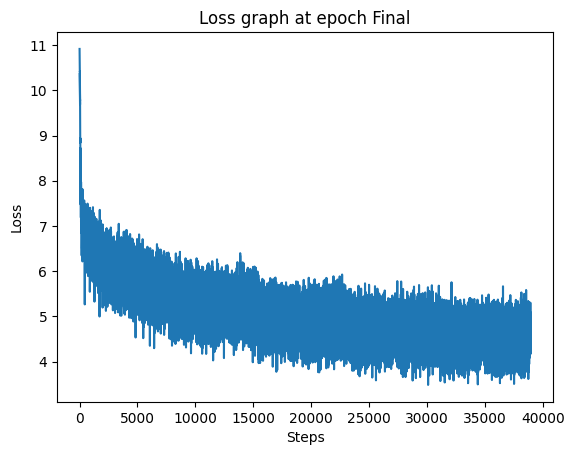     
     
Generated text: In a shocking turn of events,@ 000 people, the player can be used to be a player. 
 
 = = = = = = = = = = = = = = = = = = = = = = = = =

## Experiment Time!
I've created a Dot Product Interaction Layer, which aims to provide that functionality to compare one set of activations with itself or others directly. Attention seems like it does that. So, I hope that attention emerges from the usage of this layer. I'm going to try to use it in the transformer used above and see what happens.

In [186]:
# I've created a Dot Product Interaction Layer, which aims to provide that functionality to compare one set of activations with itself or others directly. Attention seems like it does that. So, I hope that attention emerges from the usage of this layer. I'm going to try to use it in the transformer used above and see what happens.
import torch
import torch.nn as nn
import torch.nn.functional as F

class DotProductInteractionLayer(nn.Module):
    """
    A custom layer that computes the dot product interaction between two input tensors
    using a learned interaction matrix. The interaction matrix is thresholded to 
    control the amount of interaction between elements in the input tensors.
    
    Args:
        input_dim (int): The size of the input tensor's last dimension.
        threshold (float, optional): The threshold value for the interaction matrix.
                                     Elements with an absolute value below the threshold
                                     will be set to zero. Default is 0.0.
    """
    def __init__(self, input_dim, n_head, threshold=0.0):
        super(DotProductInteractionLayer, self).__init__()
        self.input_dim = input_dim
        self.n_head = n_head
        self.threshold = threshold
        self.interaction_matrix = nn.Parameter(torch.randn(input_dim // n_head, input_dim // n_head))

    def forward(self, x, y):
        """
        Forward pass of the DotProductInteractionLayer.
        
        Args:
            x (torch.Tensor): The first input tensor of shape (batch_size, sequence_length, input_dim).
            y (torch.Tensor): The second input tensor of shape (batch_size, sequence_length, input_dim).
            
        Returns:
            interaction_output (torch.Tensor): Output tensor of shape (batch_size, sequence_length, input_dim),
                                               representing the dot product interaction between the input tensors.
        """
        print(f'x shape: {x.shape}, y shape: {y.shape}')
        # Compute the absolute interaction matrix
        abs_interaction_matrix = torch.abs(self.interaction_matrix)
        print(f'abs_interaction_matrix shape: {abs_interaction_matrix.shape}')

        # Apply thresholding to the interaction matrix
        threshold_mask = (abs_interaction_matrix > self.threshold).float()
        thresholded_interaction_matrix = abs_interaction_matrix * threshold_mask
        print(f'thresholded_interaction_matrix shape: {thresholded_interaction_matrix.shape}')

        # Compute the dot product between the input activations and the thresholded interaction matrix
        interaction_result = torch.matmul(x, thresholded_interaction_matrix)
        print(f'interaction_result shape before final matmul: {interaction_result.shape}')

        # Compute the dot product between the interaction result and the second input tensor (y)
        interaction_output = torch.matmul(interaction_result, y.transpose(-1, -2))
        
        return interaction_output
    

import torch.nn as nn
import torch.nn.functional as F
from transformers.models.gpt2.modeling_gpt2 import GPT2Attention

class CustomDotProductAttention(GPT2Attention):
    """
    Custom attention module that replaces the original self-attention mechanism in GPT-2 with a Dot Product Interaction Layer.
    
    Args:
        config (:obj:`transformers.GPT2Config`): Model configuration class with all the parameters of the model.

    """
    def __init__(self, config):
        super().__init__(config)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dk = config.n_embd // self.n_head
        self.interaction_layer = DotProductInteractionLayer(config.n_embd, config.n_head, threshold=config.attn_threshold)

    def forward(
        self,
        x,
        layer_past=None,
        attention_mask=None,
        head_mask=None,
        encoder_hidden_states=None,
        encoder_attention_mask=None,
        use_cache=False,
        output_attentions=False,
    ):
        """
        Forward pass of the custom dot product attention mechanism.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_dim).
            layer_past (Optional[torch.Tensor]): Cached past layer for faster decoding. Default is None. Unused in this implementation.
            attention_mask (Optional[torch.Tensor]): Mask to apply on the attention outputs. Default is None.
            head_mask (Optional[torch.Tensor]): Mask to apply on the attention heads. Default is None.
            encoder_hidden_states (Optional[torch.Tensor]): Encoder hidden states tensor. Default is None. Unused in this implementation.
            encoder_attention_mask (Optional[torch.Tensor]): Mask to apply on the encoder attention outputs. Default is None. Unused in this implementation.
            use_cache (bool): Whether or not to use cached layer. Default is False. Unused in this implementation.
            output_attentions (bool): Whether or not to output attention weights. Default is False. Unused in this implementation.
            
        Returns:
            attn_out (torch.Tensor): Output tensor of shape (batch_size, sequence_length, input_dim).
        """
    
        # Transform input activations into keys, queries, and values
        keys = self.c_attn(x).split(self.split_size, dim=2)
        queries, keys, values = map(lambda t: t.view(*t.size()[:-1], self.n_head, self.dk).transpose(1, 2), keys)

        print(f'queries: {queries.shape}, keys: {keys.shape}, values: {values.shape}')
        # Compute the dot product between the keys and queries using the interaction layer
        interaction_result = self.interaction_layer(queries.reshape(-1, self.dk), keys.transpose(-1, -2).reshape(-1, self.dk))

        print(f'interaction_result: {interaction_result.shape}')
        # Reshape the interaction_result to the original shape
        interaction_result = interaction_result.reshape(queries.size(0), queries.size(1), self.n_head, -1).transpose(1, 2)
        print(f'interaction_result after reshaping: {interaction_result.shape}')
        # Apply the scaling factor
        scaling_factor = self.dk ** 0.5
        interaction_logits = interaction_result / scaling_factor

        print(f'interaction_logits, before softmax: {interaction_logits.shape}')
        # Normalize the attention logits using the softmax function
        attention_weights = F.softmax(interaction_logits, dim=-1)
        print(f'attention_weights after softmax: {attention_weights.shape}')
        # # Apply the attention mask if provided
        # if attention_mask is not None:
        #     attention_weights = attention_weights * attention_mask.unsqueeze(1).unsqueeze(2).to(attention_weights.dtype)

        # # Apply the head mask if provided
        # if head_mask is not None:
        #     attention_weights = attention_weights * head_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).to(attention_weights.dtype)

        # # Compute the weighted sum of the value representations
        # print(f'attention_weights: {attention_weights.shape}, values: {values.shape}')
        # weighted_values = torch.matmul(attention_weights, values)

        # Combine the weighted values with the original input
        # attn_out = self.c_proj(weighted_values.transpose(1, 2).contiguous().view(*weighted_values.size()[:-2], self.n_embd))

        attn_out = self.c_proj(attention_weights.transpose(1, 2).contiguous().view(*attention_weights.size()[:-2], self.n_embd))
        return attn_out



In [187]:
# Example usage
# input_dim = 10
# batch_size = 5
# threshold = 0.5
# x = torch.randn(batch_size, input_dim)
# layer = DotProductInteractionLayer(input_dim, threshold)
# output = layer(x)

# print(output.shape)  # Output should have the same shape as input: (batch_size, input_dim)

In [188]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from transformers.models.gpt2.modeling_gpt2 import GPT2Attention


# class CustomGPT2Attention(GPT2Attention):
#     def __init__(self, config):
#         super().__init__(config)

#         # Replace the self-attention mechanism with the DotProductInteractionLayer
#         self.attn = DotProductInteractionLayer(config.n_embd, threshold=config.attn_threshold)

#     def forward(self, x, layer_past=None, attention_mask=None, head_mask=None):
#         # Pass the inputs through the DotProductInteractionLayer
#         x = self.attn(x)

#         # Continue with the original forward method
#         outputs = super().forward(x, layer_past=layer_past, attention_mask=attention_mask, head_mask=head_mask)
#         return outputs


In [189]:
from transformers.models.gpt2.modeling_gpt2 import GPT2Model


class CustomGPT2Model(GPT2Model):
    def __init__(self, config):
        super().__init__(config)

        # Replace the GPT2Attention layer with the CustomDotProductAttention layer
        self.h = nn.ModuleList([CustomDotProductAttention(config) for _ in range(config.n_layer)])

        # # Replace the GPT2Attention layer with the CustomGPT2Attention layer
        # self.attention = CustomGPT2Attention(config)


from transformers.models.gpt2.modeling_gpt2 import GPT2LMHeadModel

class CustomGPT2LMHeadModel(GPT2LMHeadModel):
    def __init__(self, config):
        super().__init__(config)

        # Replace the GPT2Model with the CustomGPT2Model
        self.transformer = CustomGPT2Model(config)


In [190]:
config = GPT2Config(
    vocab_size=tokenizer.vocab_size,
    n_positions=tokenizer.max_model_input_sizes["gpt2"],
    n_ctx=tokenizer.max_model_input_sizes["gpt2"],
    n_embd=256,
    n_layer=4,
    n_head=4,
    activation_function="gelu",
    attn_threshold=0.5  # Add this line
)

custom_model = CustomGPT2LMHeadModel(config)
custom_model.to(device)

CustomGPT2LMHeadModel(
  (transformer): CustomGPT2Model(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(1024, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): CustomDotProductAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (interaction_layer): DotProductInteractionLayer()
      )
      (1): CustomDotProductAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (interaction_layer): DotProductInteractionLayer()
      )
      (2): CustomDotProductAttention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
        (interaction_layer): DotProductInteractionLayer()
      )
      (3): Cus

In [191]:
# model = custom_model
optimizer, scheduler = setup()

train_loader length: 7788
Warmup fraction: 0.0012840267077555213


In [192]:
train(custom_model, optimizer, scheduler)

queries: torch.Size([8, 4, 32, 64]), keys: torch.Size([8, 4, 32, 64]), values: torch.Size([8, 4, 32, 64])
x shape: torch.Size([1024, 64]), y shape: torch.Size([1024, 64])
abs_interaction_matrix shape: torch.Size([64, 64])
thresholded_interaction_matrix shape: torch.Size([64, 64])
interaction_result shape before final matmul: torch.Size([1024, 64])
interaction_result: torch.Size([1024, 1024])
interaction_result after reshaping: torch.Size([8, 4, 4, 8192])
interaction_logits, before softmax: torch.Size([8, 4, 4, 8192])
attention_weights after softmax: torch.Size([8, 4, 4, 8192])


RuntimeError: shape '[8, 4, 256]' is invalid for input of size 1048576